In [369]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import missingno as msno

In [370]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")

<Axes: >

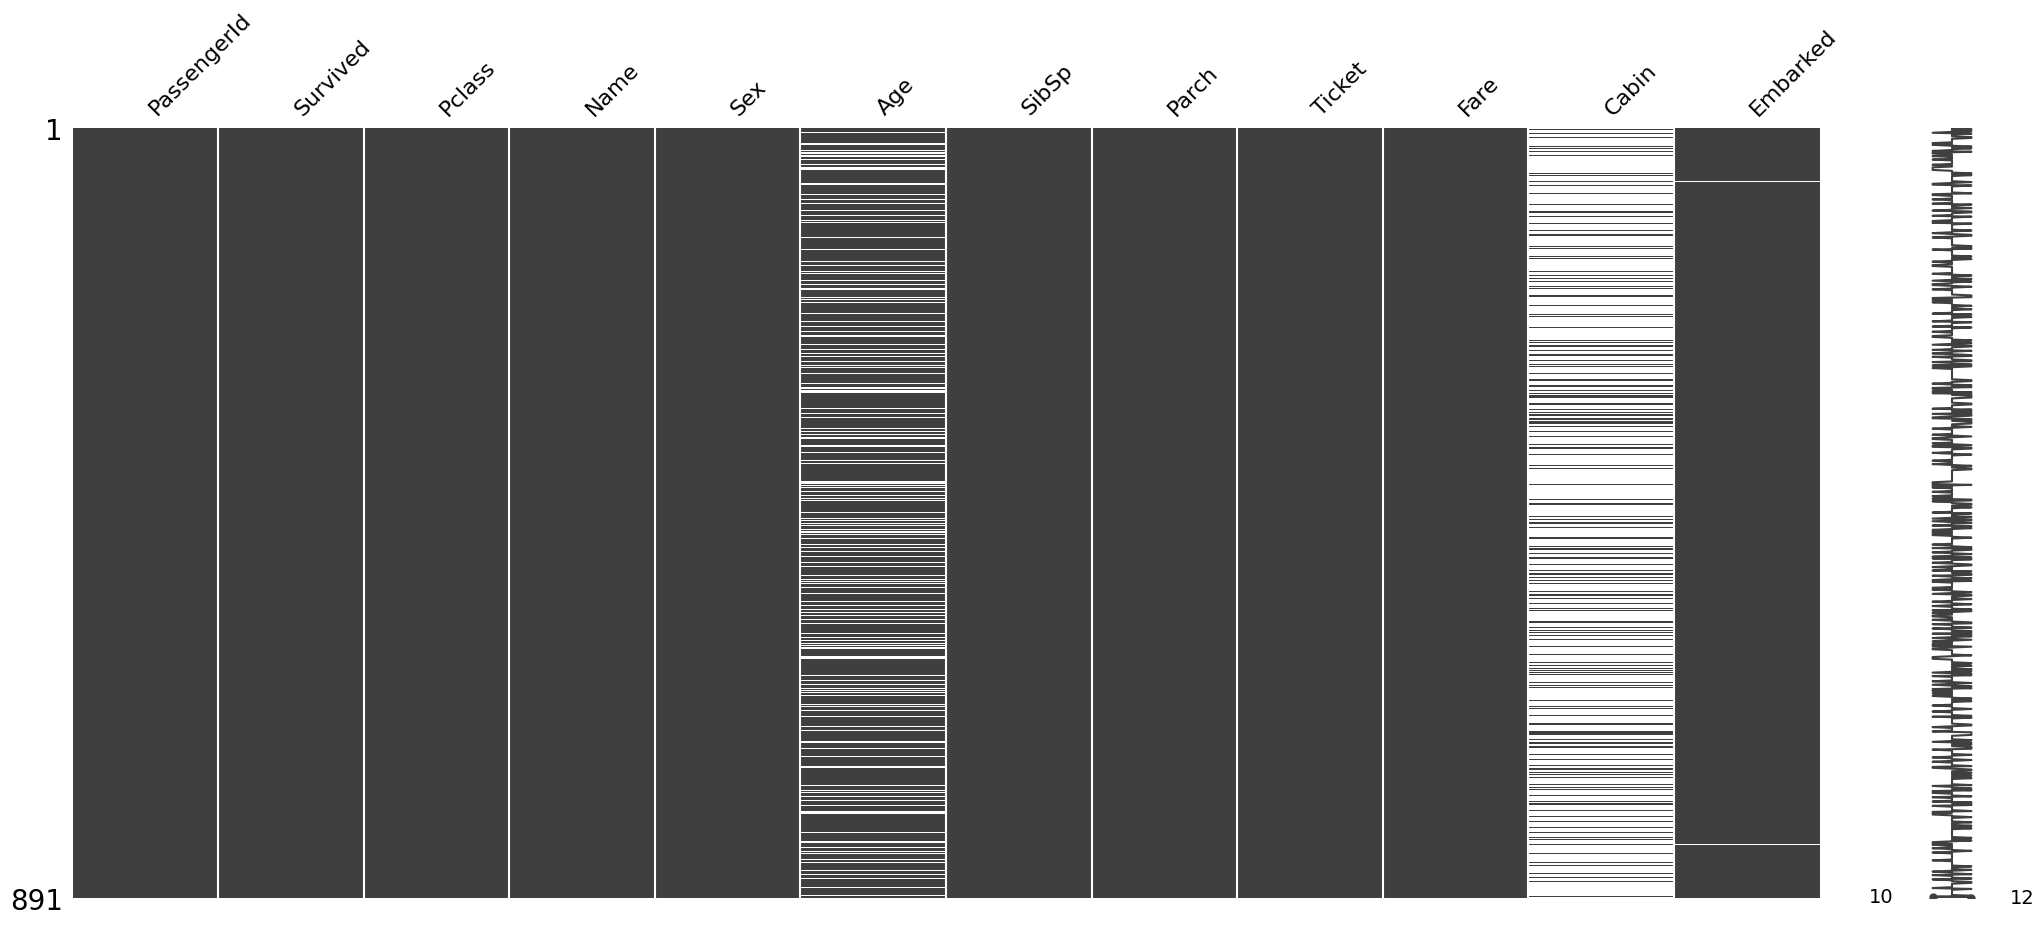

In [371]:
msno.matrix(train)

In [372]:
combined = pd.concat([train, test], keys=["train", "test"])
non_numeric_cols = combined.select_dtypes(exclude=["number"]).columns
label_encoder = LabelEncoder()
for col in non_numeric_cols:
    combined[col] = label_encoder.fit_transform(combined[col].astype(str))
    
# Separate combined data back into train and test
train = combined.xs('train')
test = combined.xs('test')

In [373]:
for column in train.columns:
    if train[column].isnull().sum() > 0:
        median_value = train[column].median()
        train[column] = train[column].fillna(median_value)
        test[column] = test[column].fillna(median_value)

C:\Users\EDWARD\AppData\Local\Temp\ipykernel_19276\2301572149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = train[column].fillna(median_value)
C:\Users\EDWARD\AppData\Local\Temp\ipykernel_19276\2301572149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[column] = test[column].fillna(median_value)


<Axes: >

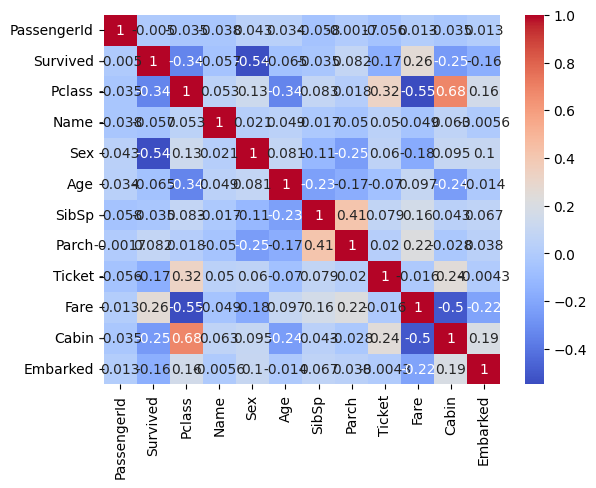

In [374]:
sns.heatmap(train.corr(), annot=True, cmap="coolwarm")

In [375]:
X = train.drop("Survived", axis=1)
y = train["Survived"]
X_test = test.drop("Survived", axis=1, errors="ignore")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [376]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False],
}

In [377]:
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


f:\anaconda\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
252 fits failed with the following error:
Traceback (most recent call last):
  File "f:\anaconda\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "f:\anaconda\envs\kaggle\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "f:\anaconda\envs\kaggle\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "f:\anaconda\envs\kaggle\lib\site-packages\s

In [378]:
# Train with best parameters
rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [379]:
# Feature importances
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

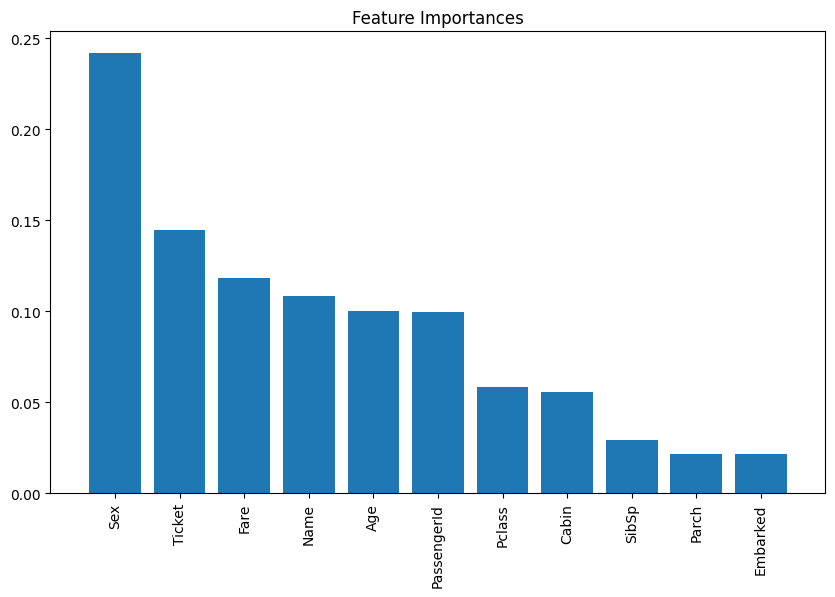

In [380]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [381]:
cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation accuracy: 0.8314 ± 0.0186


In [382]:
# Feature ranking
for f in range(X_train.shape[1]):
    print(
        f"{f + 1}. Feature {X_train.columns[indices[f]]} ({importances[indices[f]]:.4f})"
    )

1. Feature Sex (0.2416)
2. Feature Ticket (0.1444)
3. Feature Fare (0.1185)
4. Feature Name (0.1086)
5. Feature Age (0.0999)
6. Feature PassengerId (0.0997)
7. Feature Pclass (0.0584)
8. Feature Cabin (0.0556)
9. Feature SibSp (0.0296)
10. Feature Parch (0.0219)
11. Feature Embarked (0.0218)


In [383]:
joblib.dump(rf_best, "random_forest_model.joblib")

['random_forest_model.joblib']

In [384]:
predictions = rf_best.predict(X_test)
output = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": predictions})
output.to_csv("submission.csv", index=False)